In [96]:
import pandas as pd
import numpy as np
import requests
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [98]:
np.random.seed(42)

In [100]:
def load_traffic_data():
    df = pd.read_csv(r"C:\Users\hp\Downloads\Dataset_Uber Traffic.csv")
    df['DateTime'] = pd.to_datetime(df['DateTime'], format='%d/%m/%y %H:%M')
    df['date'] = df['DateTime'].dt.date
    df['hour'] = df['DateTime'].dt.hour
    df['weekday'] = df['DateTime'].dt.weekday  # Monday=0, Sunday=6
    df['month'] = df['DateTime'].dt.month
    df['is_weekend'] = df['weekday'].isin([5, 6]).astype(int)
    
    return df
traffic_df = load_traffic_data() 

In [102]:
def generate_synthetic_weather_data(start_date, end_date):
     date_range = pd.date_range(start=start_date, end=end_date, freq='h')
     weather_data = {
        'timestamp': date_range,
        'temperature': np.random.normal(loc=65, scale=15, size=len(date_range)),
        'precipitation': np.random.exponential(scale=0.1, size=len(date_range)),
        'humidity': np.random.randint(30, 90, size=len(date_range)),
        'wind_speed': np.random.exponential(scale=5, size=len(date_range)),
        'weather_condition': np.random.choice(
            ['clear', 'cloudy', 'rain', 'snow', 'fog'], 
            size=len(date_range),
            p=[0.6, 0.2, 0.15, 0.03, 0.02])
     }
    
     weather_df = pd.DataFrame(weather_data)
     weather_df['date'] = weather_df['timestamp'].dt.date
     weather_df['hour'] = weather_df['timestamp'].dt.hour
     weather_df['temperature'] = weather_df['temperature'] + 10 * np.sin(weather_df['timestamp'].dt.hour * np.pi / 12)
     weather_df['temperature'] = weather_df['temperature'] - 10 * np.cos((weather_df['timestamp'].dt.month - 1) * np.pi / 6)
    
     return weather_df

In [104]:
start_date = traffic_df['DateTime'].min()
end_date = traffic_df['DateTime'].max()
weather_df = generate_synthetic_weather_data(start_date, end_date)

In [106]:
def generate_synthetic_events(start_date, end_date):
    date_range = pd.date_range(start=start_date, end=end_date, freq='d')
    events = []
    holidays = {
        'New Year': '2016-01-01',
        'MLK Day': '2016-01-18',
        'Valentine\'s Day': '2016-02-14'
    }
    
    for name, date in holidays.items():
        events.append({
            'event_date': pd.to_datetime(date).date(),
            'event_type': 'holiday',
            'event_name': name,
            'impact_radius': 'citywide'
        })
    for date in date_range:
        if np.random.random() < 0.05:  # 5% chance of an event each day
            if np.random.random() < 0.7:  # 70% chance it's a sports event
                events.append({
                    'event_date': date.date(),
                    'event_type': 'sports',
                    'event_name': np.random.choice(['Football Game', 'Basketball Game', 'Baseball Game']),
                    'impact_radius': np.random.choice(['downtown', 'stadium_area'])
                })
            else:  # 30% chance it's a concert
                events.append({
                    'event_date': date.date(),
                    'event_type': 'concert',
                    'event_name': f"{np.random.choice(['Rock', 'Pop', 'Jazz'])} Concert",
                    'impact_radius': np.random.choice(['downtown', 'arena'])
                })
    
    return pd.DataFrame(events)

In [108]:
event_df = generate_synthetic_events(start_date, end_date)

In [110]:
def integrate_data(traffic_df, weather_df, event_df):
    merged_df = pd.merge(
        traffic_df,
        weather_df,
        on=['date', 'hour'],
        how='left'
    )
    merged_df = pd.merge(
        merged_df,
        event_df,
        left_on=['date'],
        right_on=['event_date'],
        how='left'
    )
    merged_df['has_event'] = ~merged_df['event_type'].isna()
    merged_df['event_type'] = merged_df['event_type'].fillna('no_event')
    merged_df['event_name'] = merged_df['event_name'].fillna('no_event')
    merged_df['impact_radius'] = merged_df['impact_radius'].fillna('no_impact')
    merged_df.drop(columns=['event_date', 'timestamp'], inplace=True, errors='ignore')
    
    return merged_df

In [112]:
final_df = integrate_data(traffic_df, weather_df, event_df)

In [114]:
def clean_data(df):
    weather_cols = ['temperature', 'precipitation', 'humidity', 'wind_speed', 'weather_condition']
    df[weather_cols] = df[weather_cols].ffill().bfill()
    df.drop_duplicates(subset=['ID'], keep='first', inplace=True)
    Q1 = df['Vehicles'].quantile(0.05)
    Q3 = df['Vehicles'].quantile(0.95)
    IQR = Q3 - Q1
    df['Vehicles'] = df['Vehicles'].clip(lower=Q1 - 1.5*IQR, upper=Q3 + 1.5*IQR)
    df['precipitation_binary'] = (df['precipitation'] > 0.1).astype(int)
    df['high_wind'] = (df['wind_speed'] > 15).astype(int)
    scaler = MinMaxScaler()
    numerical_cols = ['temperature', 'precipitation', 'humidity', 'wind_speed']
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
    df = pd.get_dummies(df, columns=['weather_condition', 'event_type', 'impact_radius'])
    
    return df

In [116]:
cleaned_df = clean_data(final_df.copy())

In [130]:
def perform_eda(df):
    """Perform exploratory data analysis"""
    print("\n=== Basic Dataset Info ===")
    print(f"Shape: {df.shape}")
    print(f"Time range: {df['DateTime'].min()} to {df['DateTime'].max()}")
    print("\nMissing values per column:")
    print(df.isnull().sum())
    
    print("\n=== Descriptive Statistics ===")
    print(df[['Vehicles', 'temperature', 'precipitation', 'humidity', 'wind_speed']].describe())
    
    # Plotting
    plt.figure(figsize=(15, 10))
    
    # Traffic by hour
    plt.subplot(2, 2, 1)
    sns.boxplot(x='hour', y='Vehicles', data=df)
    plt.title('Traffic Distribution by Hour')
    
    # Traffic by weekday
    plt.subplot(2, 2, 2)
    sns.boxplot(x='weekday', y='Vehicles', data=df)
    plt.title('Traffic Distribution by Weekday')
    
    # Weather impact - need to check if this column exists
    if 'weather_condition_rain' in df.columns:
        plt.subplot(2, 2, 3)
        sns.boxplot(x='weather_condition_rain', y='Vehicles', data=df)
        plt.title('Traffic During Rain vs No Rain')
    else:
        print("Warning: 'weather_condition_rain' column not found for visualization")
    
    # Event impact
    if 'has_event' in df.columns:
        plt.subplot(2, 2, 4)
        sns.boxplot(x='has_event', y='Vehicles', data=df)
        plt.title('Traffic During Events vs No Events')
    else:
        print("Warning: 'has_event' column not found for visualization")
    
    plt.tight_layout()
    plt.savefig('traffic_analysis.png')
    plt.show()
    
    # Correlation analysis
    corr_cols = ['Vehicles', 'temperature', 'precipitation', 'humidity', 'wind_speed', 
                'is_weekend', 'precipitation_binary', 'high_wind']
    # Only use columns that exist in the dataframe
    corr_cols = [col for col in corr_cols if col in df.columns]
    
    if len(corr_cols) > 1:  # Need at least 2 columns for correlation
        corr_matrix = df[corr_cols].corr()
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
        plt.title('Correlation Matrix')
        plt.savefig('correlation_matrix.png')
        plt.show()
    else:
        print("Warning: Not enough numeric columns for correlation analysis")


=== Basic Dataset Info ===
Shape: (48120, 31)
Time range: 2015-11-01 00:00:00 to 2017-06-30 23:00:00

Missing values per column:
DateTime                      0
Junction                      0
Vehicles                      0
ID                            0
date                          0
hour                          0
weekday                       0
month                         0
is_weekend                    0
temperature                   0
precipitation                 0
humidity                      0
wind_speed                    0
event_name                    0
has_event                     0
precipitation_binary          0
high_wind                     0
weather_condition_clear       0
weather_condition_cloudy      0
weather_condition_fog         0
weather_condition_rain        0
weather_condition_snow        0
event_type_concert            0
event_type_holiday            0
event_type_no_event           0
event_type_sports             0
impact_radius_arena           0
impact

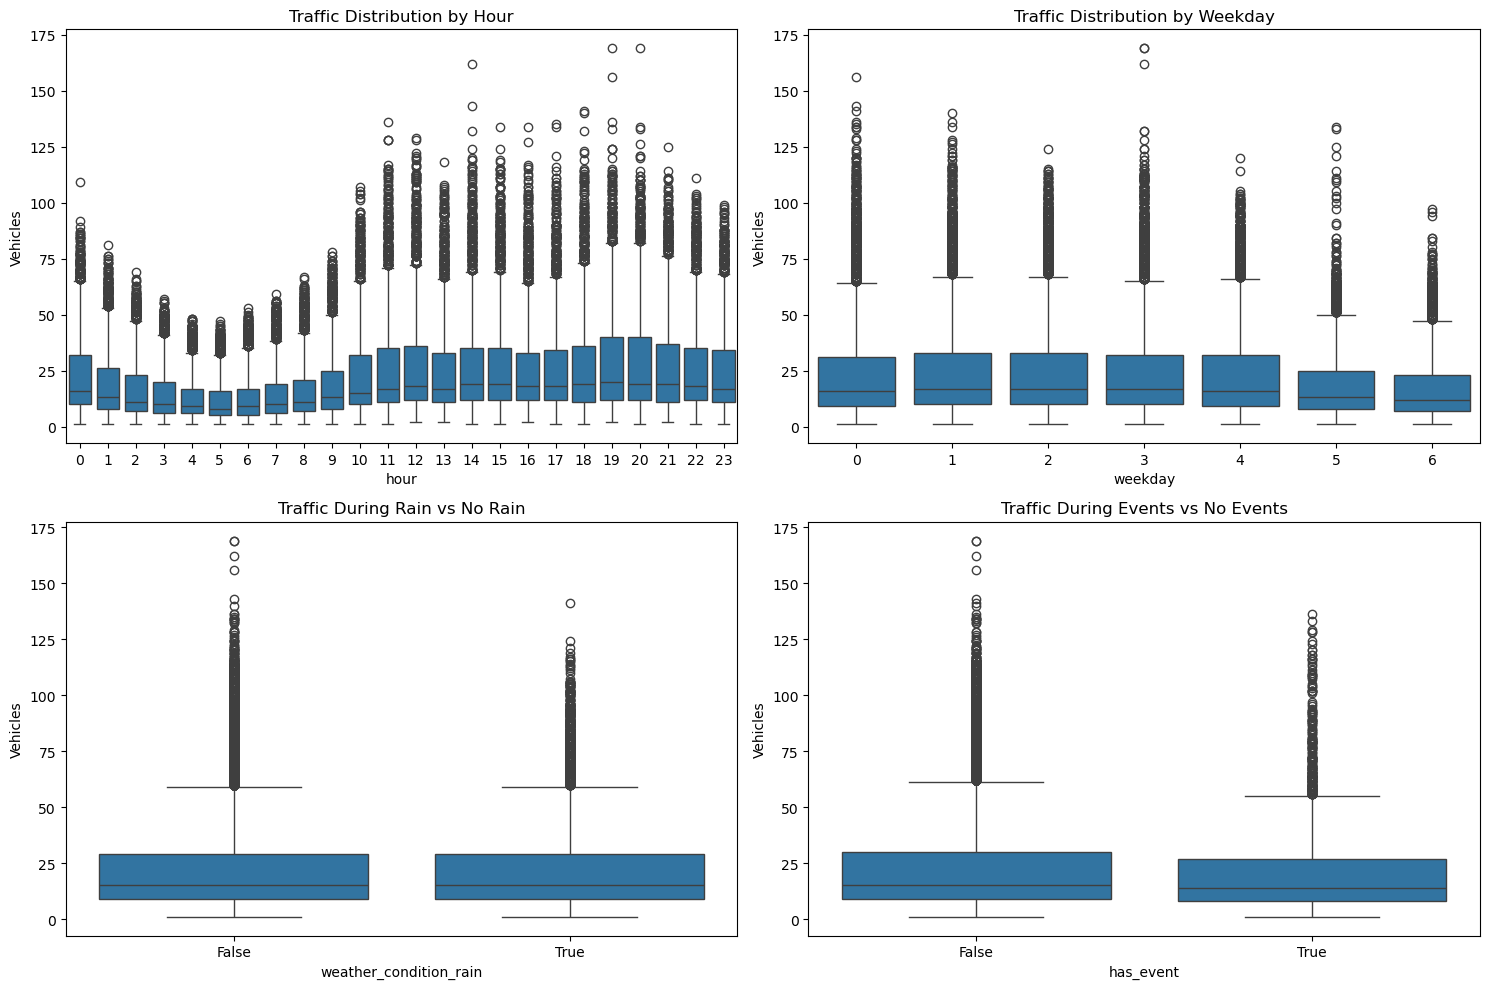

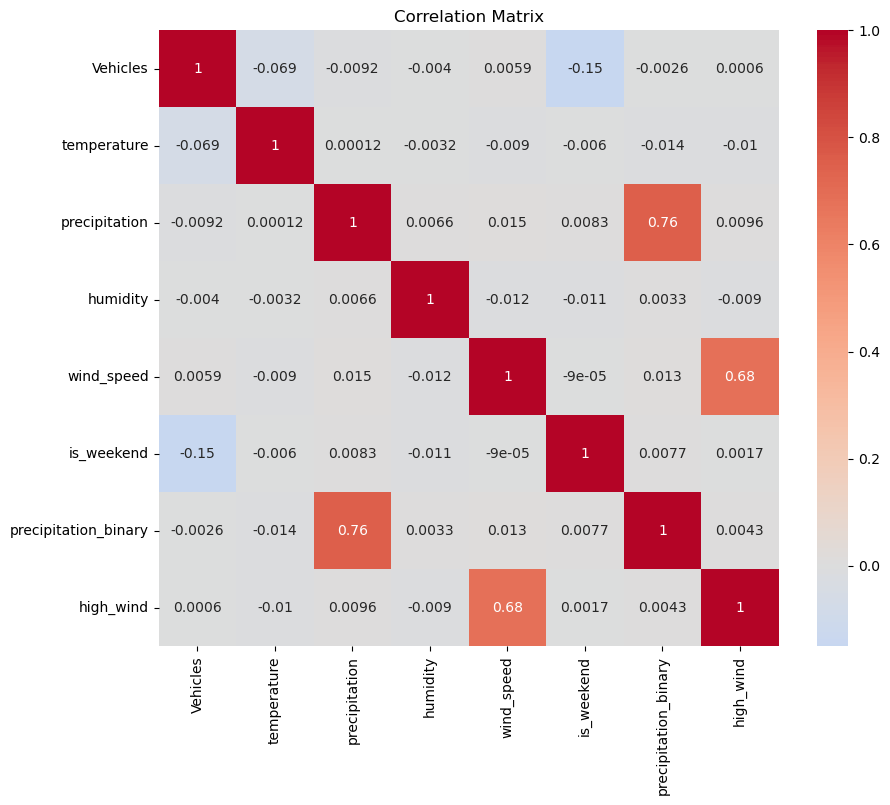

In [132]:
perform_eda(cleaned_df)

In [134]:
cleaned_df.to_csv('processed_uber_traffic.csv', index=False)
print("Processing complete. Saved cleaned data to 'processed_uber_traffic.csv'")

Processing complete. Saved cleaned data to 'processed_uber_traffic.csv'
